# PARSING, PICS & STATS

Import packages:

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Import data from DrugBank (might take some time). Delete `xmlns="http://www.drugbank.ca"` from the file before reading (to ease the parsing process).

In [2]:
tree = ET.parse('../data/drugbank/drugbank_full_db.xml')
root = tree.getroot()

Create 3 dicts for targets and drugs from DrugBank database:

In [3]:
drugs = {}
targets = {}
targets_selected = {}
targets_approved = {}
targets_experimental = {}
targets_none = {}

for child in root:                                          # for every drug
    
    id = child.find("drugbank-id").text                     # get the drug's id
    name = child.find("name").text                          # get the drug's name
    statuses = []                                         
    for status in child.find("groups").findall("group"):    # get the drug's statuses
        statuses.append(status.text)
    try:
        mass = float(child.find("average-mass").text)       # get the drug's mass
    except:
        mass = -1                                           # if not specified set '-1'

    n_targets = 0
    for target in child.find("targets").findall("target"):  # get all targets for the drug
        n_targets += 1
        
        target_id = target.find("id").text                  # get the target's id
        target_name = target.find("name").text              # get the target's name
        organism = target.find("organism").text             # get the target's organism
        
        # try to find the target's UniProt & GenBank IDs
        # if not specified set '-'
        try: 
            for ex_id in target.find("polypeptide").find("external-identifiers").findall("external-identifier"):
                if ex_id.find("resource").text == "GenBank Gene Database": GB = ex_id.find("identifier").text    
                elif ex_id.find("resource").text == "UniProtKB": UP = ex_id.find("identifier").text
        except: 
            GB = "-"
            UP = "-"
        
        # add the target to the `targets` dict
        if target_id not in targets:
            targets[target_id] = {
                "name": target_name,
                "organism": organism,
                "GenBank_ID": GB,
                "UniProt_ID": UP,
                "drugs": id
            }    
        else:
            targets[target_id]["drugs"] = targets[target_id]["drugs"] + "; " + id
        
        # add the target to the `targets_selected` dict
        if (mass > 100) & (mass < 1000) & (organism == "Humans"):
            if target_id not in targets_selected:
                targets_selected[target_id] = {
                    "name": target_name,
                    "organism": organism,
                    "GenBank_ID": GB,
                    "UniProt_ID": UP,
                    "drugs": id
                }    
            else:
                targets_selected[target_id]["drugs"] = targets_selected[target_id]["drugs"] + "; " + id

            # add the target to the `targets_approved` dict
            if "approved" in statuses:
                if target_id not in targets_approved:
                    targets_approved[target_id] = {
                        "name": target_name,
                        "organism": organism,
                        "GenBank_ID": GB,
                        "UniProt_ID": UP,
                        "drugs": id
                    }    
                else:
                    targets_approved[target_id]["drugs"] = targets_approved[target_id]["drugs"] + "; " + id
                    
            # add the target to the `targets_experimental` dict
            if ("approved" not in statuses) and ("experimental" in statuses):
                if target_id not in targets_experimental:
                    targets_experimental[target_id] = {
                        "name": target_name,
                        "organism": organism,
                        "GenBank_ID": GB,
                        "UniProt_ID": UP,
                        "drugs": id
                    }    
                else:
                    targets_experimental[target_id]["drugs"] = targets_experimental[target_id]["drugs"] + "; " + id
            
            # add the target to the `targets_none` dict
            if ("approved" not in statuses) and ("experimental" not in statuses):
                if target_id not in targets_none:
                    targets_none[target_id] = {
                        "name": target_name,
                        "organism": organism,
                        "GenBank_ID": GB,
                        "UniProt_ID": UP,
                        "drugs": id
                    }    
                else:
                    targets_none[target_id]["drugs"] = targets_none[target_id]["drugs"] + "; " + id
    
    # add the drug to the `drugs` dict
    drugs[id] = {
        "name": name,
        "status": ";".join(statuses),
        "mass": mass,
        "targets": n_targets}


Create a dataframe from `drugs` dict:

In [4]:
drugs_df = pd.DataFrame.from_dict(drugs, orient="index")
print(drugs_df.shape)
drugs_df.head()

(13339, 4)


,name,status,mass,targets
DB00001,Lepirudin,approved,-1.0,1
DB00002,Cetuximab,approved,-1.0,12
DB00003,Dornase alfa,approved,-1.0,1
DB00004,Denileukin diftitox,approved;investigational,-1.0,3
DB00005,Etanercept,approved;investigational,-1.0,14


Plot the distribution of drugs mass:

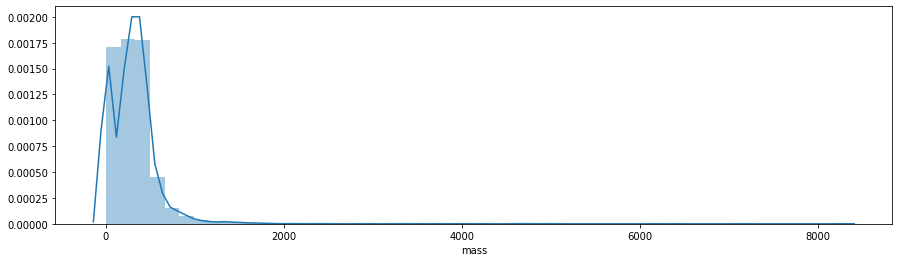

In [5]:
plt.figure(figsize=(15,4))
sns.distplot(drugs_df["mass"])
#sns.distplot(drugs_df[drugs_df["mass"] < 600]["mass"]) closer

Plot the distribution of drugs approval status:

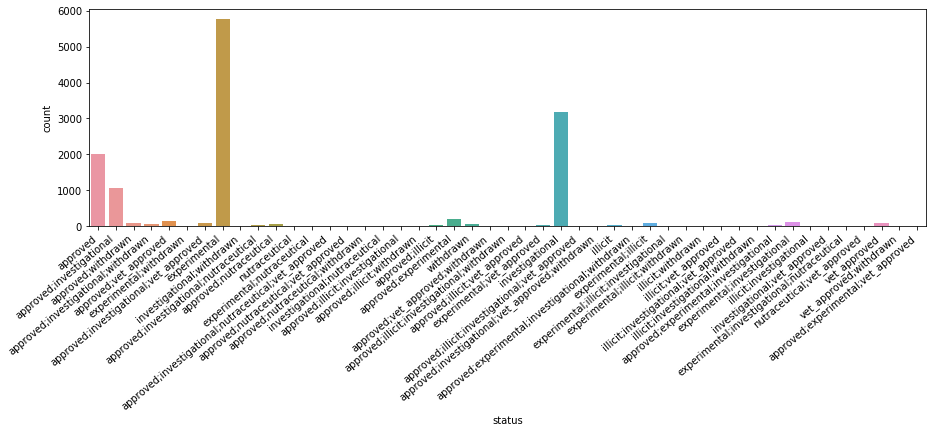

In [8]:
plt.figure(figsize=(15,4))
plot = sns.countplot(x="status", data=drugs_df)
plot.set_xticklabels(plot.get_xticklabels(), rotation=40, ha="right");

Plot the distribution of drugs targets number:

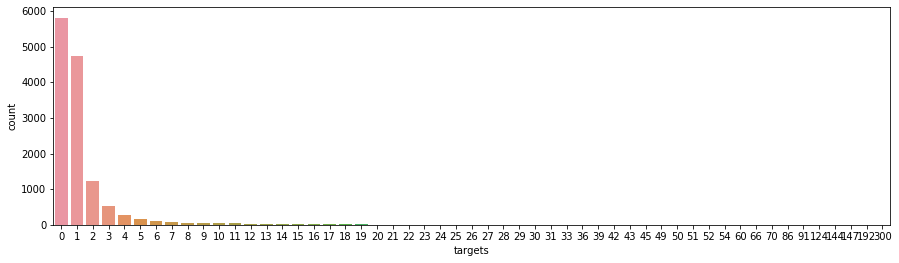

In [9]:
plt.figure(figsize=(15,4))
sns.countplot(x="targets", data=drugs_df);

Create a dataframe from `targets` dict:

In [11]:
targets_df = pd.DataFrame.from_dict(targets, orient="index")
targets_df['drugs_num'] = targets_df['drugs'].str.split(';').agg([len]) # add a column with drugs number
print(targets_df.shape)
targets_df.head()

(4897, 6)


,name,organism,GenBank_ID,UniProt_ID,drugs,drugs_num
BE0000048,Prothrombin,Humans,M17262,P00734,DB00001; DB00006; DB00055; DB00100; DB00170; D...,115
BE0000767,Epidermal growth factor receptor,Humans,X00588,P00533,DB00002; DB00072; DB00281; DB00317; DB00530; D...,30
BE0000901,Low affinity immunoglobulin gamma Fc region re...,Humans,X16863,O75015,DB00002; DB00005; DB00028; DB00054; DB00056; D...,19
BE0002093,Complement C1r subcomponent,Humans,X04701,P00736,DB00002; DB00005; DB00054; DB00056; DB00072; D...,21
BE0002094,Complement C1q subcomponent subunit A,Humans,AF135157,P02745,DB00002; DB00005; DB00054; DB00056; DB00072; D...,16


Plot the distribution of drugs number:

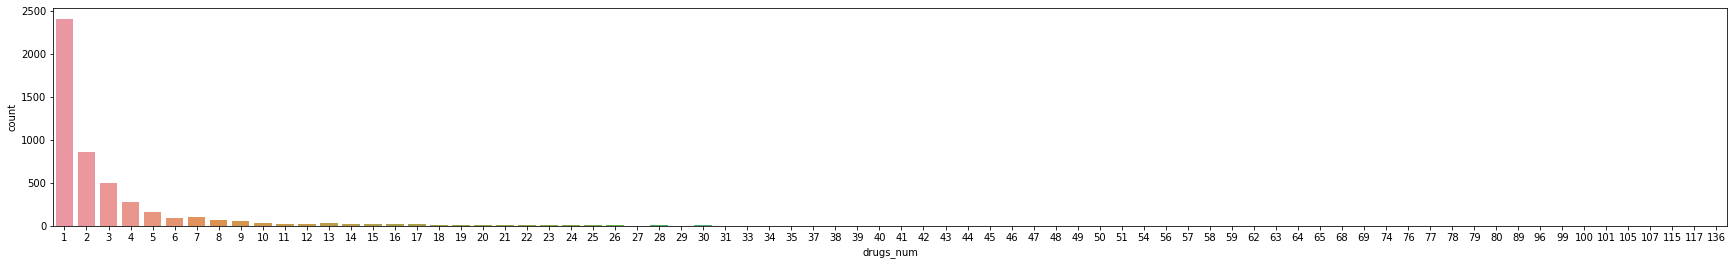

In [12]:
plt.figure(figsize=(30,4))
sns.countplot(x="drugs_num", data=targets_df);

Create a dataframe from `targets_selected` dict:

In [13]:
targets_sel_df = pd.DataFrame.from_dict(targets_selected, orient="index")
targets_sel_df['drugs_num'] = targets_sel_df['drugs'].str.split(';').agg([len]) # add a column with drugs number
print(targets_sel_df.shape)
targets_sel_df.head()

(2555, 6)


,name,organism,GenBank_ID,UniProt_ID,drugs,drugs_num
BE0000102,"Alanine--glyoxylate aminotransferase 2, mitoch...",Humans,AJ292204,Q9BYV1,DB00114,1
BE0000378,Glutamate decarboxylase 1,Humans,M81883,Q99259,DB00114; DB00142,2
BE0000323,Cystathionine beta-synthase,Humans,L19501,P35520,DB00114; DB00118; DB00133; DB00151,4
BE0000392,Kynureninase,Humans,U57721,Q16719,DB00114; DB07069,2
BE0000331,"Serine hydroxymethyltransferase, cytosolic",Humans,L11931,P34896,DB00114; DB00116; DB01055; DB02067; DB02800; D...,6


Plot the distribution of drugs number:

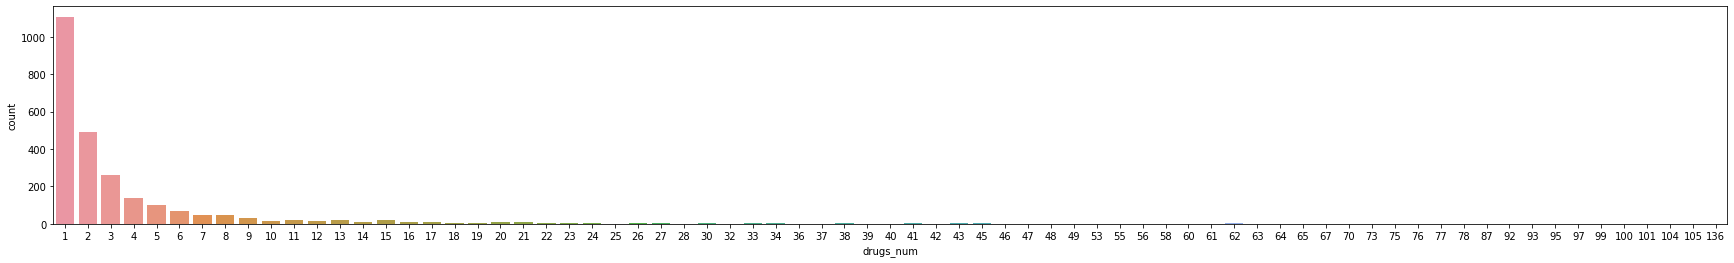

In [14]:
plt.figure(figsize=(30,4))
sns.countplot(x="drugs_num", data=targets_sel_df);

Create a dataframe from `targets_approved` dict:

In [15]:
targets_app_df = pd.DataFrame.from_dict(targets_approved, orient="index")
targets_app_df['drugs_num'] = targets_app_df['drugs'].str.split(';').agg([len]) # add a column with drugs number
print(targets_app_df.shape)
targets_app_df.head()

(1883, 6)


,name,organism,GenBank_ID,UniProt_ID,drugs,drugs_num
BE0000102,"Alanine--glyoxylate aminotransferase 2, mitoch...",Humans,AJ292204,Q9BYV1,DB00114,1
BE0000378,Glutamate decarboxylase 1,Humans,M81883,Q99259,DB00114; DB00142,2
BE0000323,Cystathionine beta-synthase,Humans,L19501,P35520,DB00114; DB00118; DB00133; DB00151,4
BE0000392,Kynureninase,Humans,U57721,Q16719,DB00114,1
BE0000331,"Serine hydroxymethyltransferase, cytosolic",Humans,L11931,P34896,DB00114,1


Plot the distribution of drugs number:

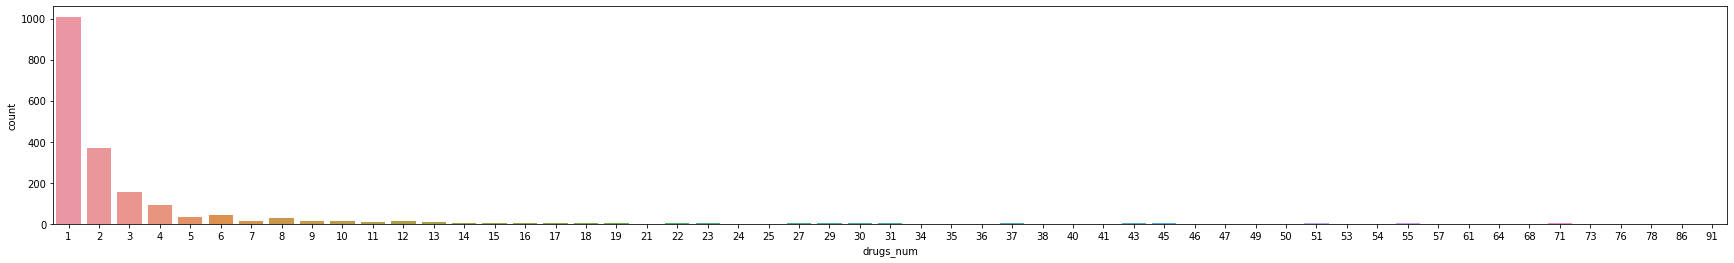

In [16]:
plt.figure(figsize=(30,4))
sns.countplot(x="drugs_num", data=targets_app_df);

Create a dataframe from `targets_experimental` dict:

In [17]:
targets_exp_df = pd.DataFrame.from_dict(targets_experimental, orient="index")
targets_exp_df['drugs_num'] = targets_exp_df['drugs'].str.split(';').agg([len]) # add a column with drugs number
print(targets_exp_df.shape)
targets_exp_df.head()

(1184, 6)


,name,organism,GenBank_ID,UniProt_ID,drugs,drugs_num
BE0000964,Spermine synthase,Humans,Z49099,P52788,DB00127,1
BE0000566,Spermine oxidase,Humans,AY033889,Q9NWM0,DB00127,1
BE0004796,DNA,Humans,-,-,DB00127; DB00614; DB01702; DB02379; DB02842; D...,6
BE0000404,Ornithine decarboxylase,Humans,M16650,P11926,DB00127; DB02209; DB02824; DB03856; DB04083; D...,6
BE0000509,Extracellular calcium-sensing receptor,Humans,X81086,P41180,DB00127,1


Plot the distribution of drugs number:

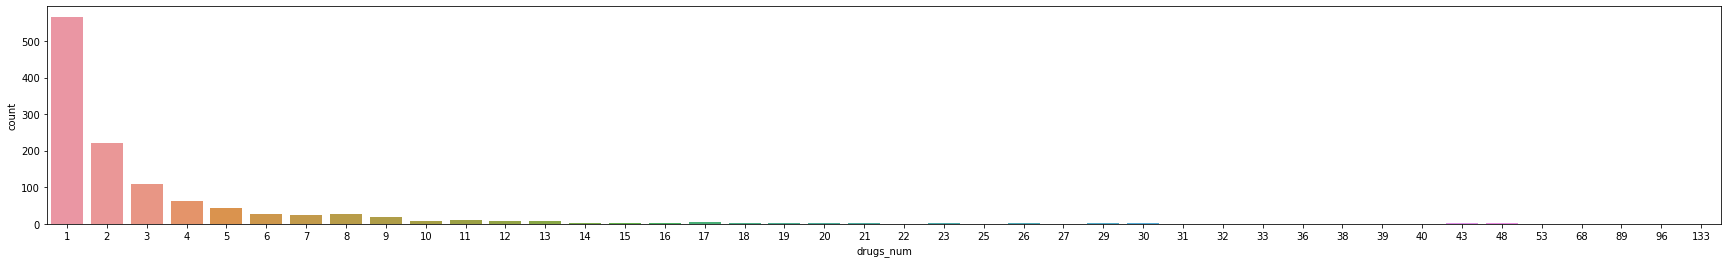

In [18]:
plt.figure(figsize=(30,4))
sns.countplot(x="drugs_num", data=targets_exp_df);

Create a dataframe from `targets_none` dict:

In [19]:
targets_none_df = pd.DataFrame.from_dict(targets_none, orient="index")
targets_none_df['drugs_num'] = targets_none_df['drugs'].str.split(';').agg([len]) # add a column with drugs number
print(targets_none_df.shape)
targets_none_df.head()

(593, 6)


,name,organism,GenBank_ID,UniProt_ID,drugs,drugs_num
BE0000617,"C-1-tetrahydrofolate synthase, cytoplasmic",Humans,J04031,P11586,DB00116,1
BE0000268,Bifunctional methylenetetrahydrofolate dehydro...,Humans,X16396,P13995,DB00116,1
BE0000010,"Aminomethyltransferase, mitochondrial",Humans,D13811,P48728,DB00116; DB04789,2
BE0000933,Cytosolic 10-formyltetrahydrofolate dehydrogenase,Humans,AF052732,O75891,DB00116,1
BE0000734,Methionine synthase,Humans,U71285,Q99707,DB00116,1


Plot the distribution of drugs number:

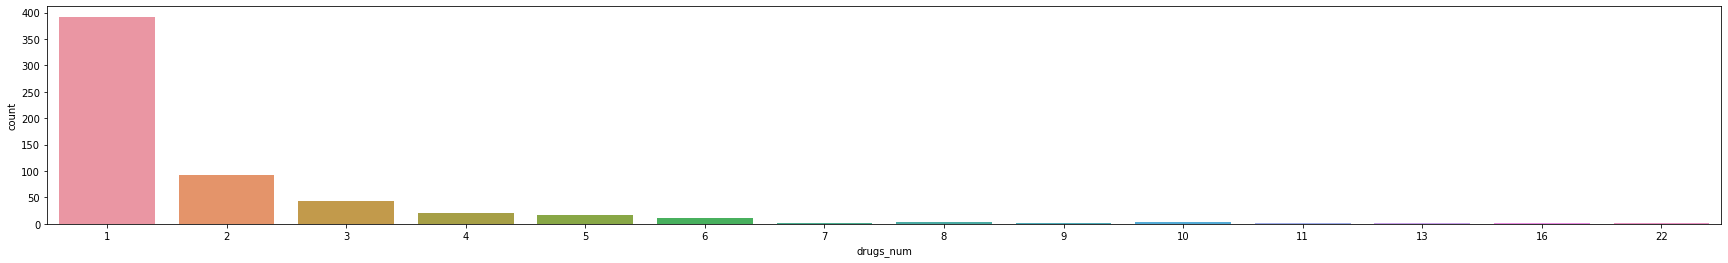

In [20]:
plt.figure(figsize=(30,4))
sns.countplot(x="drugs_num", data=targets_none_df);

Export dataframes to `.csv` tables:

In [21]:
targets_df.to_csv("../results/targets_from_xml_all.csv")
drugs_df.to_csv("../results/drugs_from_xml_all.csv")
targets_sel_df.to_csv("../results/targets_from_xml_selected.csv")
targets_app_df.to_csv("../results/targets_from_xml_selected_approved.csv")
targets_exp_df.to_csv("../results/targets_from_xml_selected_experimental.csv")
targets_none_df.to_csv("../results/targets_from_xml_selected_none.csv")